****Import Library****

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pickle
from imblearn.over_sampling import SMOTE
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

****Tambahkan dataset tanaman****

In [2]:
df = pd.read_csv("../Dataset/rekomendasi_tanaman.csv")
df.head()
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,49.225714,53.672381,48.537619,25.647571,71.093299,6.456942,100.067030
std,37.194613,33.695004,51.803317,5.174487,22.683467,0.784002,53.848519
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,20.000000,27.000000,20.000000,22.602437,59.237124,5.948298,63.489314
50%,36.000000,52.000000,30.000000,25.667383,80.532760,6.414227,91.978786
75%,84.000000,69.000000,50.000000,28.684566,90.194600,6.910487,117.368990
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


****Penilaian Data****

In [3]:
# Memeriksa apakah ada data yang kosong atau missing value
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2100 non-null   int64  
 1   P            2100 non-null   int64  
 2   K            2100 non-null   int64  
 3   temperature  2100 non-null   float64
 4   humidity     2100 non-null   float64
 5   ph           2100 non-null   float64
 6   rainfall     2100 non-null   float64
 7   label        2100 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 131.4+ KB


In [5]:
# menghapus kolom yang tidak di perlukan
df = df.drop(['N','P','K','rainfall','ph'], axis=1)

In [6]:
# Memperbarui kolom "temperature" dan "humidity" dengan nilai bulat ke atas
df['temperature'] = df['temperature'].apply(math.ceil).astype(int)
df['humidity'] = df['humidity'].apply(math.ceil).astype(int)

# Menampilkan dataframe setelah pembulatan nilai
print(df)

      temperature  humidity label
0              21        83  padi
1              22        81  padi
2              24        83  padi
3              27        81  padi
4              21        82  padi
...           ...       ...   ...
2095           27        67  kopi
2096           28        57  kopi
2097           25        68  kopi
2098           27        53  kopi
2099           24        61  kopi

[2100 rows x 3 columns]


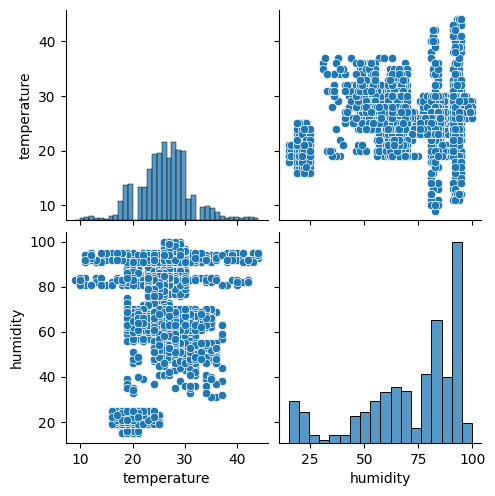

In [7]:
sns.pairplot(df[[ 'temperature', 'humidity']])

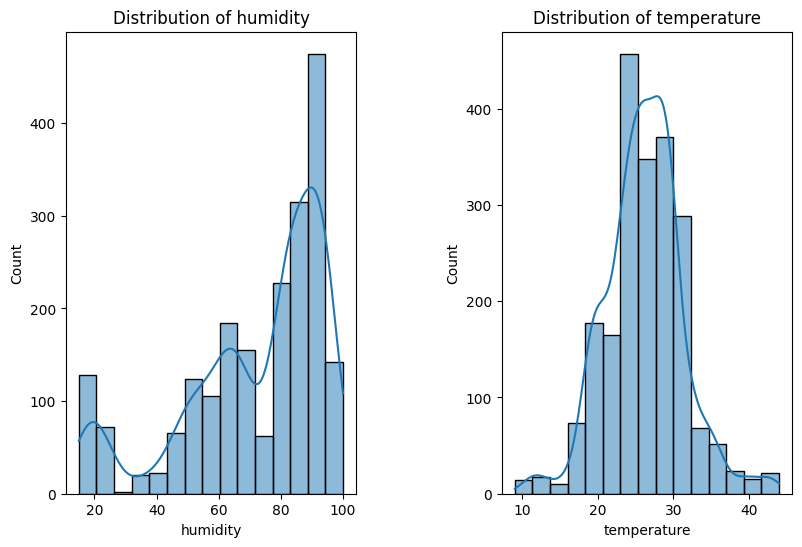

In [8]:
plt.figure(1, figsize=(15, 6))
n = 0
for x in ['humidity', 'temperature']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.histplot(df[x], bins=15, kde=True)  # Gunakan histplot dengan kde=True
    plt.title('Distribution of {}'.format(x))

plt.show()

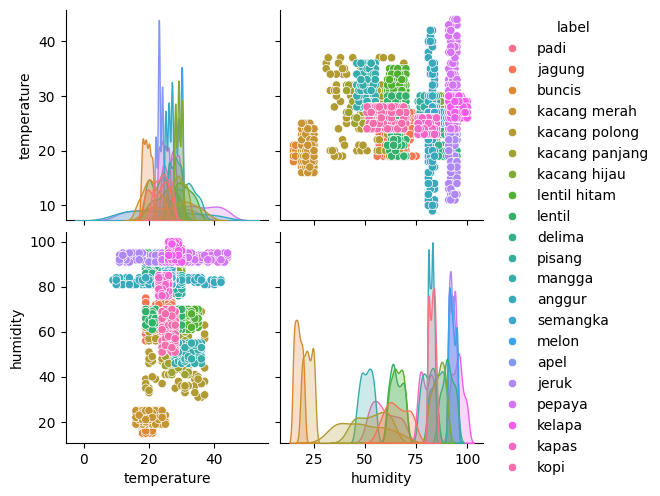

In [9]:
sns.pairplot(df, vars = ['temperature', 'humidity'], hue = "label")

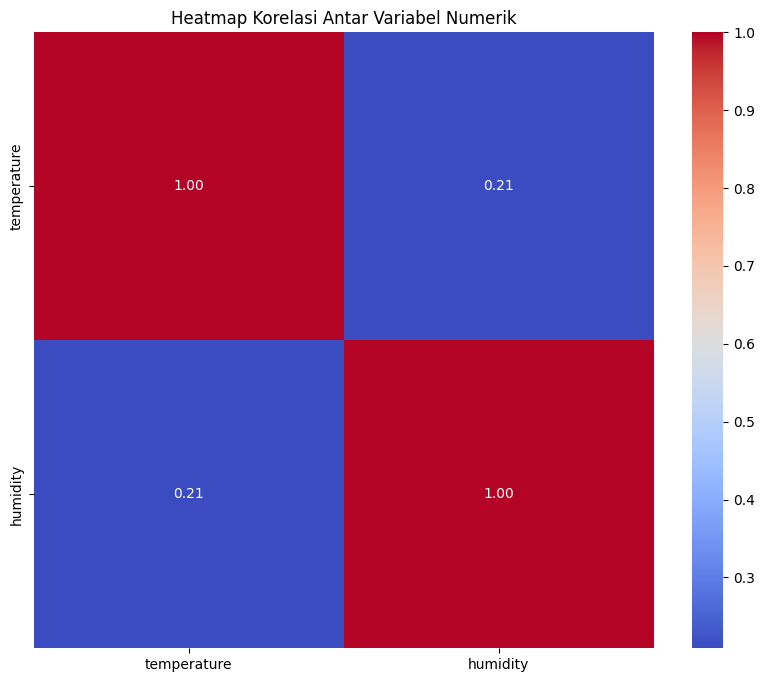

In [10]:
# Pilih hanya kolom numerik
numeric_df = df.select_dtypes(include='number')

# Hitung korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Variabel Numerik')
plt.show()

**Pra Processing data**

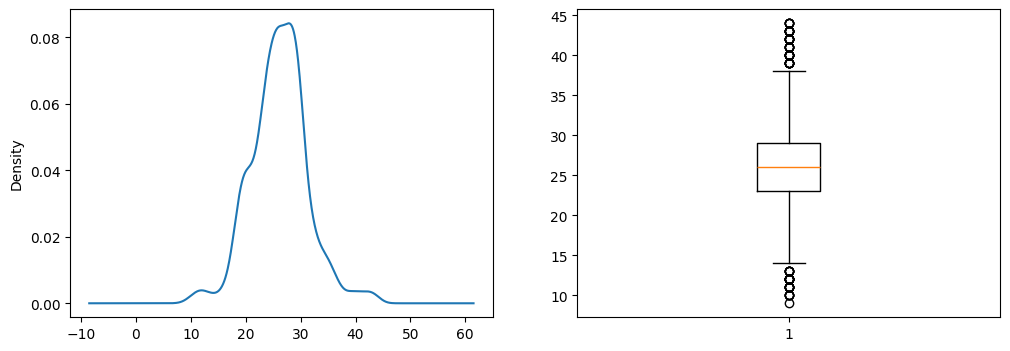

In [11]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
df['temperature'].plot(kind='kde')
f.add_subplot(1,2,2)
plt.boxplot(df['temperature'])
plt.show()

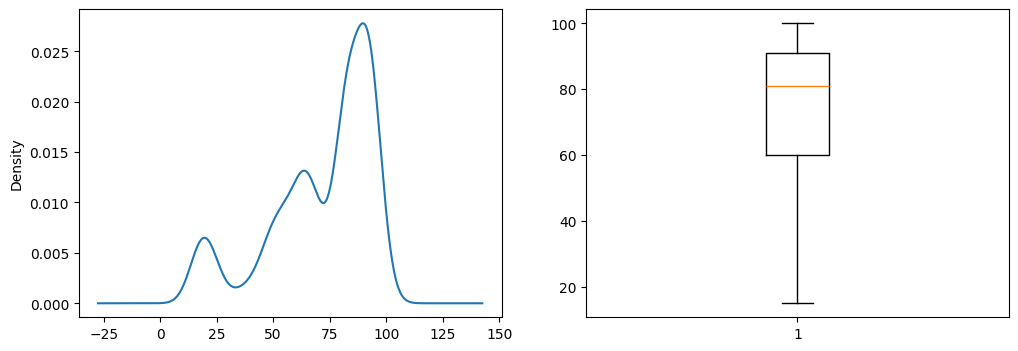

In [12]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
df['humidity'].plot(kind='kde')
f.add_subplot(1,2,2)
plt.boxplot(df['humidity'])
plt.show()

<Axes: xlabel='temperature'>

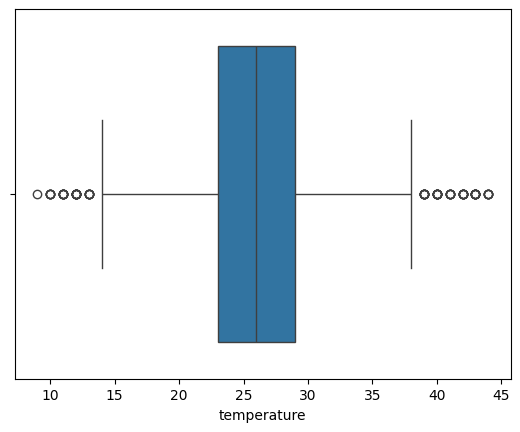

In [13]:
sns.boxplot(x=df['temperature'])

<Axes: xlabel='humidity'>

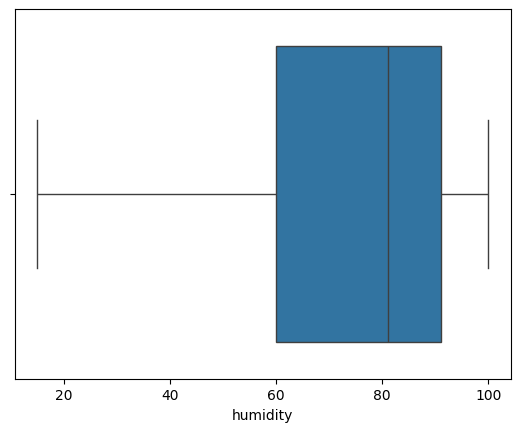

In [14]:
sns.boxplot(x=df['humidity'])

In [15]:
Q1 = df['temperature'].quantile(0.25)
Q3 = df['temperature'].quantile(0.75)
IQR = Q3 - Q1
boxplot_min = Q1 - 1.5 * IQR
boxplot_max = Q3 + 1.5 * IQR
print('Q1:\n',Q1)
print('\nQ3:\n',Q3)
print('\nIQR:\n',IQR)
print('\nMin:\n',boxplot_min)
print('\nMax:\n',boxplot_max)

Q1:
 23.0

Q3:
 29.0

IQR:
 6.0

Min:
 14.0

Max:
 38.0


In [16]:
filter_min = df['temperature']<boxplot_min
filter_max = df['temperature']>boxplot_max
data_df = df[~(filter_min|filter_max)] 
data_df.shape

(2024, 3)

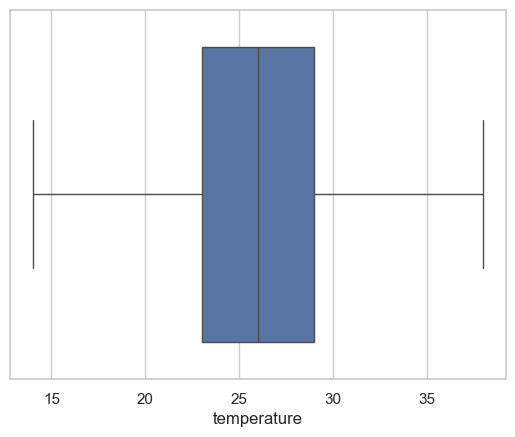

In [17]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_df['temperature'])

In [18]:
data_df.isnull().sum()

temperature    0
humidity       0
label          0
dtype: int64

In [19]:
# Menghapus kolom yang tidak digunakan
df_clean = data_df.copy()

In [20]:
df_clean.value_counts()

temperature  humidity  label        
30           91        melon            13
23           91        apel             11
             93        apel             11
30           95        melon            11
23           95        apel             10
                                        ..
37           32        kacang polong     1
36           94        pepaya            1
             84        anggur            1
             69        kacang polong     1
16           95        jeruk             1
Name: count, Length: 1045, dtype: int64

In [21]:
df_clean.tail()

,temperature,humidity,label
2095,27,67,kopi
2096,28,57,kopi
2097,25,68,kopi
2098,27,53,kopi
2099,24,61,kopi


In [22]:
for feat in df_clean.columns:
    hh = df_clean.groupby(feat)['label'].count()
    print(feat,',', 'Unique :',len(df_clean[feat].unique()))

temperature , Unique : 25
humidity , Unique : 81
label , Unique : 21


In [23]:
df_clean[[ 'temperature', 'humidity','label']]

,temperature,humidity,label
0,21,83,padi
1,22,81,padi
2,24,83,padi
3,27,81,padi
4,21,82,padi
...,...,...,...
2095,27,67,kopi
2096,28,57,kopi
2097,25,68,kopi
2098,27,53,kopi


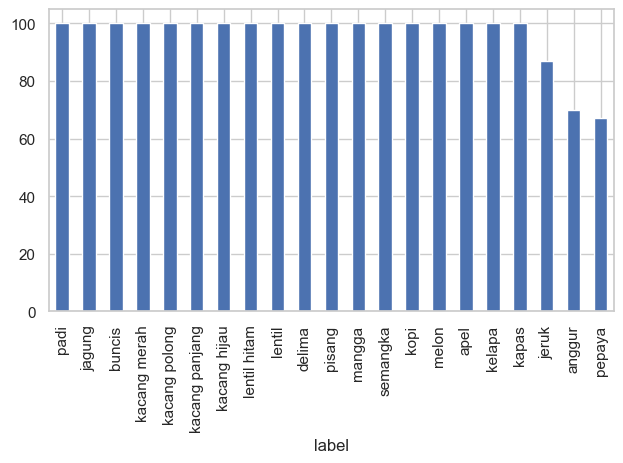

In [24]:
df_clean['label'].value_counts().plot.bar()
plt.tight_layout()
plt.show()

**Data sintetis**

Data sintetis adalah data yang dibuat secara artifisial untuk meniru data dunia nyata, namun tidak berisi informasi yang sama.

In [25]:
# Menambahkan nama kolom
df_clean.columns = ['temperature', 'humidity', 'label']

# Menampilkan jumlah sampel sebelum SMOTE
print("Jumlah sampel sebelum SMOTE:")
print(df_clean['label'].value_counts())
print("=============================")

Jumlah sampel sebelum SMOTE:
label
padi              100
jagung            100
buncis            100
kacang merah      100
kacang polong     100
kacang panjang    100
kacang hijau      100
lentil hitam      100
lentil            100
delima            100
pisang            100
mangga            100
semangka          100
kopi              100
melon             100
apel              100
kelapa            100
kapas             100
jeruk              87
anggur             70
pepaya             67
Name: count, dtype: int64


In [26]:
# Memisahkan fitur dan target
X = df_clean[['temperature', 'humidity']]
y = df_clean['label']

# Menerapkan SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Membentuk dataset baru setelah SMOTE
# Membuat dataset baru setelah SMOTE
df_resampled = pd.DataFrame(X_res, columns=['temperature', 'humidity'])
df_resampled['label'] = y_res

# Menampilkan jumlah sampel setelah SMOTE
print("\nJumlah sampel setelah SMOTE:")
print(y_res.value_counts())


Jumlah sampel setelah SMOTE:
label
padi              100
jagung            100
buncis            100
kacang merah      100
kacang polong     100
kacang panjang    100
kacang hijau      100
lentil hitam      100
lentil            100
delima            100
pisang            100
mangga            100
anggur            100
semangka          100
melon             100
apel              100
jeruk             100
pepaya            100
kelapa            100
kapas             100
kopi              100
Name: count, dtype: int64


c:\Users\PC\.conda\envs\tas\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\PC\.conda\envs\tas\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


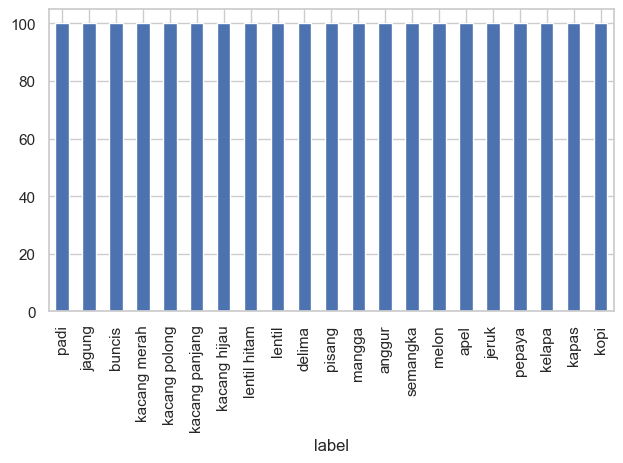

In [27]:
y_res.value_counts().plot.bar()
plt.tight_layout()
plt.show()

***Split Data Train dan Data Test***

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=10)

print('training dataset:')
print(X_train.shape)
print(y_train.shape)
print()
print('testing dataset:')
print(X_test.shape)
print(y_test.shape)

training dataset:
(1680, 2)
(1680,)

testing dataset:
(420, 2)
(420,)


***kmens Models***

In [29]:
df_resampled = df_resampled.drop(['label'],axis=1)
df_resampled

,temperature,humidity
0,21,83
1,22,81
2,24,83
3,27,81
4,21,82
...,...,...
2095,24,94
2096,26,94
2097,24,94
2098,32,91


***Menentukan Jumlah Cluster dengan metode silhouette_scores***

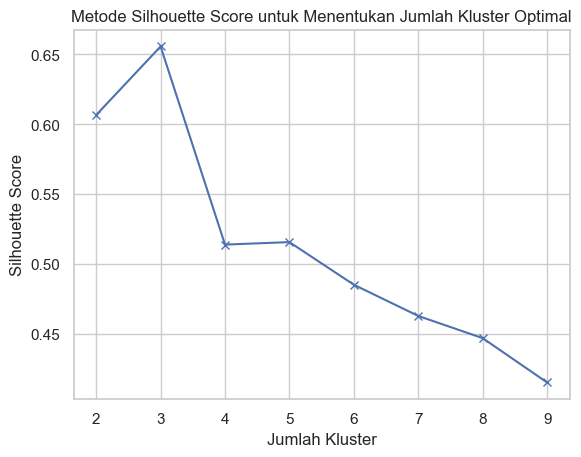

In [30]:
# Menyimpan skor siluet untuk setiap jumlah kluster
silhouette_scores = []

# K range untuk percobaan jumlah kluster
k_range = range(2, 10)

# Melakukan klasterisasi dan menghitung skor siluet untuk setiap jumlah kluster
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_resampled)
    labels = kmeans.labels_
    score = silhouette_score(df_resampled, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Jumlah Kluster')
plt.ylabel('Silhouette Score')
plt.title('Metode Silhouette Score untuk Menentukan Jumlah Kluster Optimal')
plt.show()

***Menentukan Jumlah Cluster dengan metode Elbow***

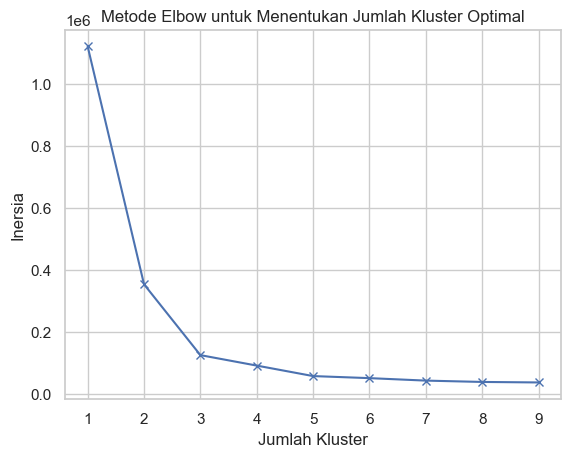

In [31]:
# Menyimpan nilai inersia untuk setiap jumlah kluster
inertia = []

# K range untuk percobaan jumlah kluster
k_range = range(1, 10)

# Melakukan klasterisasi untuk setiap jumlah kluster
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_resampled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(k_range, inertia, 'bx-')
plt.xlabel('Jumlah Kluster')
plt.ylabel('Inersia')
plt.title('Metode Elbow untuk Menentukan Jumlah Kluster Optimal')
plt.show()


## Inisialisasi model K-Means ##

Berdasarkan pengujian metode Elbow dan Silhouette Score untuk menentukan jumlah cluster didapat hasil yaitu 3 cluster optimal

In [32]:
# Jumlah kluster yang diinginkan
n_clusters = 3

# Inisialisasi model K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Melatih model dengan data tanaman
kmeans.fit(X_res)

# Menggambarkan pusat-pusat kluster
centers = kmeans.cluster_centers_

# Prediksi kluster untuk data tanaman
labels = kmeans.labels_

# Cetak pusat-pusat kluster
print("Pusat-Pusat Kluster:")
print(centers)

# Cetak kluster untuk setiap data tanaman
print("\nKluster untuk Setiap Data Tanaman:")
for i, label in enumerate(labels):
    print(f"Data {i+1}: Kluster {label+1}")

Pusat-Pusat Kluster:
[[27.61052632 59.14285714]
 [26.11423841 87.83360927]
 [20.96035242 21.57709251]]

Kluster untuk Setiap Data Tanaman:
Data 1: Kluster 2
Data 2: Kluster 2
Data 3: Kluster 2
Data 4: Kluster 2
Data 5: Kluster 2
Data 6: Kluster 2
Data 7: Kluster 2
Data 8: Kluster 2
Data 9: Kluster 2
Data 10: Kluster 2
Data 11: Kluster 2
Data 12: Kluster 2
Data 13: Kluster 2
Data 14: Kluster 2
Data 15: Kluster 2
Data 16: Kluster 2
Data 17: Kluster 2
Data 18: Kluster 2
Data 19: Kluster 2
Data 20: Kluster 2
Data 21: Kluster 2
Data 22: Kluster 2
Data 23: Kluster 2
Data 24: Kluster 2
Data 25: Kluster 2
Data 26: Kluster 2
Data 27: Kluster 2
Data 28: Kluster 2
Data 29: Kluster 2
Data 30: Kluster 2
Data 31: Kluster 2
Data 32: Kluster 2
Data 33: Kluster 2
Data 34: Kluster 2
Data 35: Kluster 2
Data 36: Kluster 2
Data 37: Kluster 2
Data 38: Kluster 2
Data 39: Kluster 2
Data 40: Kluster 2
Data 41: Kluster 2
Data 42: Kluster 2
Data 43: Kluster 2
Data 44: Kluster 2
Data 45: Kluster 2
Data 46: Kluste

In [33]:
kmeans.cluster_centers_

array([[27.61052632, 59.14285714],
       [26.11423841, 87.83360927],
       [20.96035242, 21.57709251]])

In [34]:
inertia = kmeans.inertia_
print("Inertia:", inertia)

Inertia: 124265.3895029954


In [35]:
df_resampled['label'] = y_res

### Display Ploting Data Cluster ###

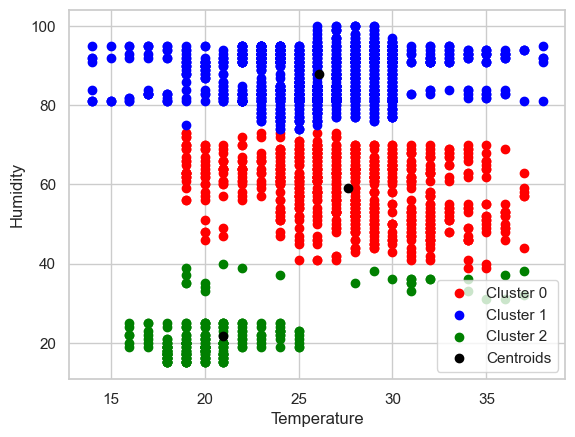

In [36]:
# Fit k-Means pada dataset
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_res)

# Mengambil label cluster yang telah dipredisksi 
y_kmeans = kmeans.predict(X_res)

# Membuat scatter plot
plt.scatter(X_res[y_kmeans == 0]['temperature'], X_res[y_kmeans == 0]['humidity'], c='red', label='Cluster 0')
plt.scatter(X_res[y_kmeans == 1]['temperature'], X_res[y_kmeans == 1]['humidity'], c='blue', label='Cluster 1')
plt.scatter(X_res[y_kmeans == 2]['temperature'], X_res[y_kmeans == 2]['humidity'], c='green', label='Cluster 2')

# Ploting centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', label='Centroids')

# Menambahkan label untuk sumbu x dan y
plt.xlabel('Temperature')
plt.ylabel('Humidity')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [37]:
filename = f'model_kmeans.pickle'

# save model clustering kmeans
pickle.dump(kmeans, open(filename, "wb"))
print(f'Model Kmeans berhasil disimpan dengan nama {filename}')

Model Kmeans berhasil disimpan dengan nama model_kmeans.pickle


### Pemisahan data frame setiap cluster ###

In [38]:
# Membuat dataframe baru dari setiap cluster
df_clusters = df_resampled.copy()
df_clusters['cluster'] = y_kmeans

# Memisahkan dataframe setiap cluster 
cluster_dfs = {}
for cluster_label in range(kmeans.n_clusters):
    cluster_dfs[cluster_label] = df_clusters[df_clusters['cluster'] == cluster_label].drop('cluster', axis=1)

# Print labels setiap cluster
for cluster_label, cluster_df in cluster_dfs.items():
    print(f"Cluster {cluster_label}:")
    labels = cluster_df['label'].unique()
    print("Labels:", labels)
    print("=============================")

Cluster 0:
Labels: ['jagung' 'kacang polong' 'kacang panjang' 'lentil hitam' 'lentil'
 'mangga' 'kopi']
Cluster 1:
Labels: ['padi' 'jagung' 'kacang hijau' 'delima' 'pisang' 'anggur' 'semangka'
 'melon' 'apel' 'jeruk' 'pepaya' 'kelapa' 'kapas']
Cluster 2:
Labels: ['buncis' 'kacang merah' 'kacang polong']


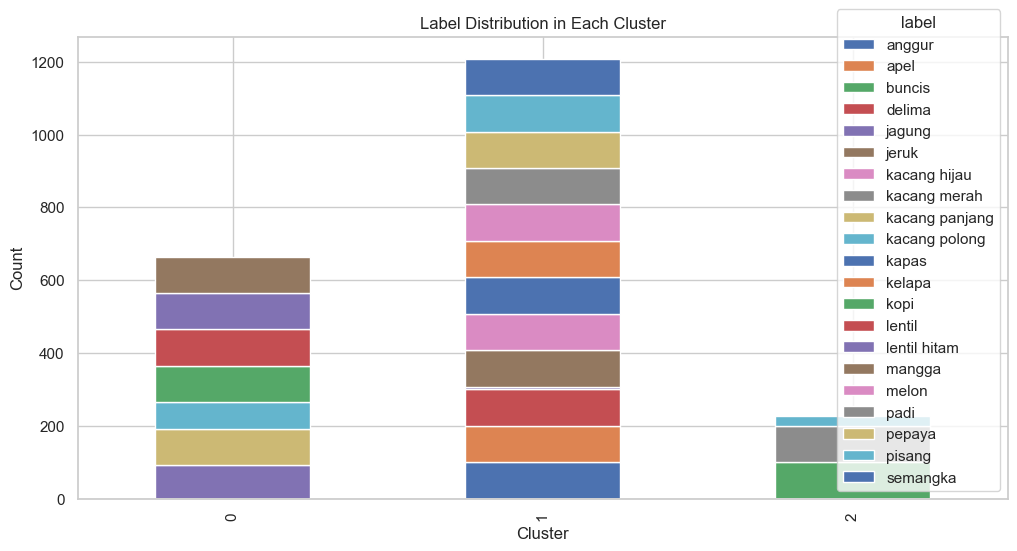

In [39]:
# Membuat bar plot untuk melihat distribusi label pada setiap cluster
cluster_counts = df_clusters.groupby(['cluster', 'label']).size().unstack()
cluster_counts.plot(kind='bar', stacked=True)

# Set Judul dan label dari plot data
plt.title('Label Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Set ukuran lebar figure
fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.show()

In [40]:
# Export setiap cluster menjadi dataframe baru
for cluster_label in df_clusters['cluster'].unique():
    cluster_df = df_clusters[df_clusters['cluster'] == cluster_label]
    cluster_df.to_csv(f'cluster_{cluster_label}.csv', index=False)

### Klasifikasi untuk setiap cluster ###

In [41]:
file_names = ['cluster_0.csv', 'cluster_1.csv', 'cluster_2.csv']

# Inisialisasi dictionary untuk menyimpan DataFrame untuk setiap cluster
dataframes = {}

# Perulangan untuk membaca dan membuat DataFrame untuk setiap cluster
for cluster_file in file_names:
    # Membaca file CSV dan membuat DataFrame
    df = pd.read_csv(cluster_file)
    
    # Menyimpan DataFrame ke dalam dictionary dengan key sesuai nama cluster
    cluster_name = cluster_file.split('.')[0]  # Mengambil nama cluster dari nama file
    dataframes[cluster_name] = df

# DataFrame untuk cluster_0
df_cluster_0 = dataframes['cluster_0']
print("DataFrame untuk cluster_0:")
print(df_cluster_0.head())

# DataFrame untuk cluster_1
df_cluster_1 = dataframes['cluster_1']
print("DataFrame untuk cluster_1:")
print(df_cluster_1.head())

# DataFrame untuk cluster_2
df_cluster_2 = dataframes['cluster_2']
print("DataFrame untuk cluster_2:")
print(df_cluster_2.head())


DataFrame untuk cluster_0:
   temperature  humidity   label  cluster
0           23        64  jagung        0
1           27        72  jagung        0
2           24        72  jagung        0
3           20        58  jagung        0
4           19        63  jagung        0
DataFrame untuk cluster_1:
   temperature  humidity label  cluster
0           21        83  padi        1
1           22        81  padi        1
2           24        83  padi        1
3           27        81  padi        1
4           21        82  padi        1
DataFrame untuk cluster_2:
   temperature  humidity   label  cluster
0           18        17  buncis        2
1           20        18  buncis        2
2           18        16  buncis        2
3           19        16  buncis        2
4           19        20  buncis        2


In [42]:
def classify_clusters(cluster_data):
    highest_accuracy = 0.0
    best_cluster = None

    for cluster_name, cluster_df in cluster_data.items():
        # Mengambil fitur dan label dari DataFrame
        X = cluster_df.drop('label', axis=1)
        y = cluster_df['label']

        # Membuat model Decision Tree Classifier
        # model = DecisionTreeClassifier()
        model = RandomForestClassifier()
        # Melakukan pelatihan model
        model.fit(X, y)

        filename = f'model_{cluster_name}.pickle'

        # save model setiap cluster
        pickle.dump(model, open(filename, "wb"))
        print(f'Model {filename} berhasil disimpan')

        # Melakukan prediksi menggunakan model
        y_pred = model.predict(X)

        # Menghitung akurasi model
        accuracy = accuracy_score(y, y_pred)

        print(accuracy)

        # Membandingkan akurasi dengan nilai tertinggi sejauh ini
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_cluster = cluster_name

    # Mengembalikan DataFrame dengan nilai akurasi tertinggi
    return cluster_data[best_cluster]

# Memanggil fungsi classify_clusters untuk cluster_0, cluster_1, dan cluster_2
dataframes = {'cluster_0': df_cluster_0, 'cluster_1': df_cluster_1, 'cluster_2': df_cluster_2}
best_cluster_df = classify_clusters(dataframes)

print("DataFrame dengan nilai akurasi tertinggi:")
print(best_cluster_df.head())

Model model_cluster_0.pickle berhasil disimpan
0.7458646616541353
Model model_cluster_1.pickle berhasil disimpan
0.7301324503311258
Model model_cluster_2.pickle berhasil disimpan
0.9427312775330396
DataFrame dengan nilai akurasi tertinggi:
   temperature  humidity   label  cluster
0           18        17  buncis        2
1           20        18  buncis        2
2           18        16  buncis        2
3           19        16  buncis        2
4           19        20  buncis        2


***Penerapan Model***

In [46]:
# Input variabel temperature & humidity
input = [[21,80]]

In [47]:
# Load model clustering
filename = 'model_kmeans.pickle'
loaded_kmeans_model = pickle.load(open(filename, "rb"))

# Eksekusi model
predict_cluster = loaded_kmeans_model.predict(input)

# Mengambil label cluster 
predict_cluster_int = predict_cluster[0]

# Menambahkan label cluster kedalam var input untuk proses
input[0].append(predict_cluster_int)


print(f'Cluster {predict_cluster_int}')
print(input[0])

Cluster 1
[21, 80, np.int32(1)]


c:\Users\PC\.conda\envs\tas\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [48]:
# Load model klasifikasi
filename = f'model_cluster_{predict_cluster_int}.pickle'
loaded_model = pickle.load(open(filename, "rb"))

# Eksekusi model klasifikasi
predict_cluster = loaded_model.predict(input)

print(f'Cluster {predict_cluster_int}')
print(f'Tanaman yang cocok dengan lahan adalah tanaman {predict_cluster[0]}')
print(input)

Cluster 1
Tanaman yang cocok dengan lahan adalah tanaman kapas
[[21, 80, np.int32(1)]]


c:\Users\PC\.conda\envs\tas\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
